In [9]:
%pip install geopandas matplotlib pandas geodatasets


  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (34 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.0-cp39-cp39-macosx_11_0_arm64.whl (120 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd

# Load the CSV file into a DataFrame
output = pd.read_csv('output.csv')

# Display the first few rows of the DataFrame
print(output.head())


      timestamp constellation        AGC   SNR   latitude  longitude  height
0  1.725971e+12       GLONASS  59.924477  66.0  69.212375  15.858584    11.8
1  1.725971e+12           GPS  28.133144  70.0  69.212375  15.858584    11.8
2  1.725971e+12       Galileo  28.133144  58.0  69.212375  15.858584    11.8
3  1.725971e+12       GLONASS  61.720665  66.0  69.212369  15.858604    11.9
4  1.725971e+12           GPS  26.674500  70.0  69.212369  15.858604    11.9


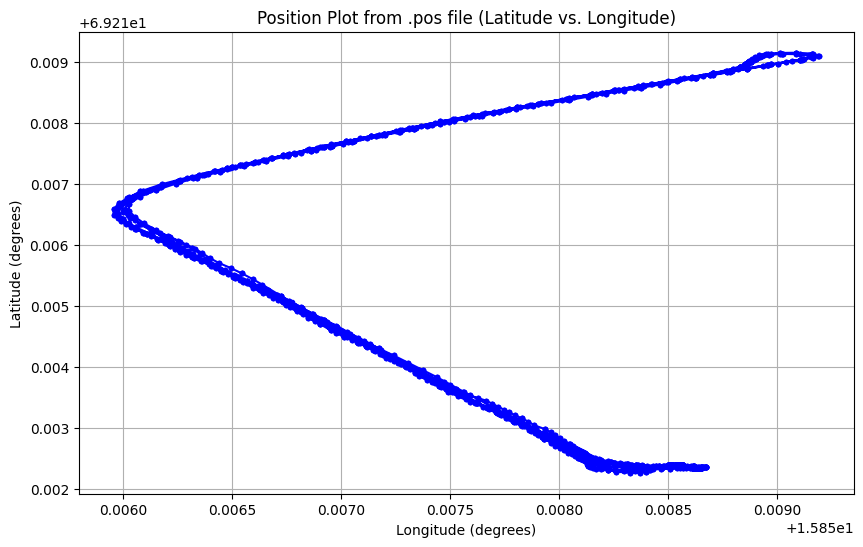

In [26]:
# Convert GPST column to datetime if needed
#pos_data["GPST"] = pd.to_datetime(pos_data["GPST"])

# Plot latitude and longitude (Position Plot)
plt.figure(figsize=(10, 6))
plt.plot(output["longitude"], output["latitude"], marker='o', markersize=3, linestyle='-', color='blue')
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.title("Position Plot from .pos file (Latitude vs. Longitude)")
plt.grid()
plt.show()

In [27]:
# Load the .pos file in the same directory
pos_file = "gnss_log_2024_09_10_14_21_50.pos"
pos_data = pd.read_csv(
    pos_file,
    delim_whitespace=True,
    skiprows=17,  # Skip header lines
    names=[
        "GPST", "latitude", "longitude", "height", "Q", "ns", "sdn", "sde", "sdu", 
        "sdne", "sdeu", "sdun", "age", "ratio"
    ]
)

/var/folders/t0/89_6kll106x3rw0lt8xmdcmc0000gn/T/ipykernel_29576/1762298775.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pos_data = pd.read_csv(


/var/folders/t0/89_6kll106x3rw0lt8xmdcmc0000gn/T/ipykernel_29576/2592650337.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pos_data["GPST"] = pd.to_datetime(pos_data["GPST"])


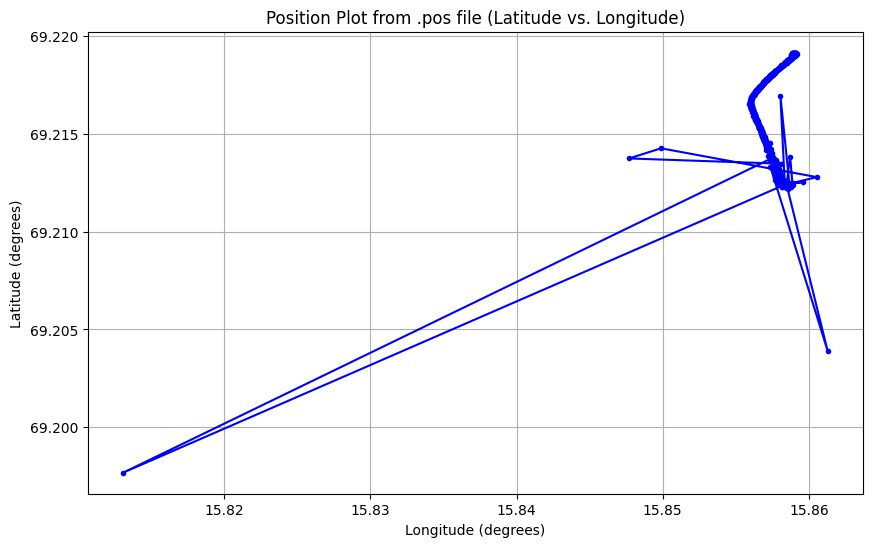

In [28]:
# Convert GPST column to datetime if needed
pos_data["GPST"] = pd.to_datetime(pos_data["GPST"])

# Plot latitude and longitude (Position Plot)
plt.figure(figsize=(10, 6))
plt.plot(pos_data["longitude"], pos_data["latitude"], marker='o', markersize=3, linestyle='-', color='blue')
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.title("Position Plot from .pos file (Latitude vs. Longitude)")
plt.grid()
plt.show()

      unix_time  distance                   speed
0  1.725970e+09   30878.6  0.0 kilometer_per_hour
1  1.725970e+09   30878.6  0.0 kilometer_per_hour
2  1.725970e+09   30878.6  0.0 kilometer_per_hour
3  1.725970e+09   30878.6  0.0 kilometer_per_hour
4  1.725970e+09   30878.6  0.0 kilometer_per_hour
Empty DataFrame
Columns: [unix_time, distance, speed, timestamp, speed_numeric]
Index: []


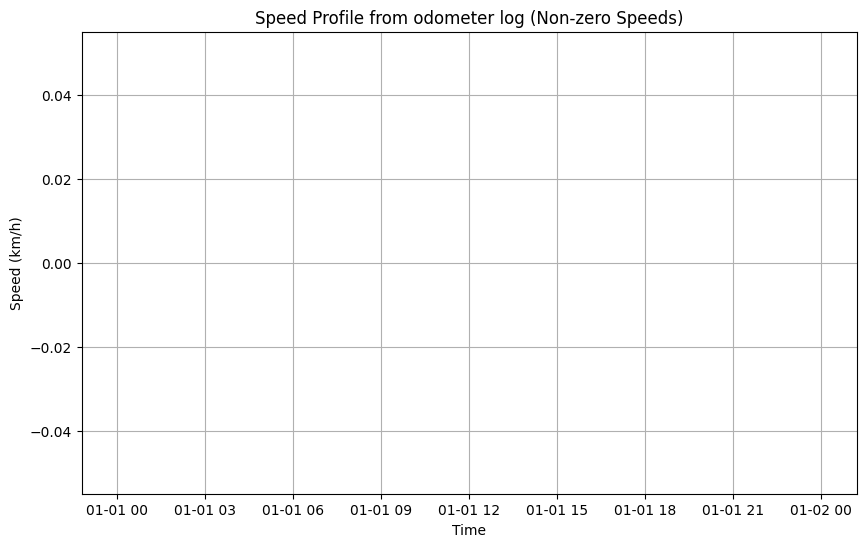

In [45]:

# Load the odometer log file in the same directory
odo_file = "odometer_2024-09-10T1407.log"
odo_data = pd.read_csv(odo_file, 
                    skiprows=1,          # Skip first line
                    sep=',',             # Comma separator
                    skipinitialspace=True,  # Skip spaces after comma
                    names=['unix_time', 'distance', 'speed'])  # Column names


# Convert unix_time to numeric, forcing non-numeric values to NaN, then drop NaNs
odo_data["unix_time"] = pd.to_numeric(odo_data["unix_time"], errors="coerce")
odo_data = odo_data.dropna(subset=["unix_time"])

print(odo_data.head())
# Convert cleaned unix_time to datetime
odo_data["timestamp"] = pd.to_datetime(odo_data["unix_time"], unit="s")

# Extract numeric part of 'speed' and convert to float
odo_data['speed_numeric'] = odo_data['speed'].str.extract(r'([0-9.]+)').astype(float)

# Filter out zero speed values for plotting
odo_data['speed'] = pd.to_numeric(odo_data['speed'], errors='coerce')
odo_data_non_zero = odo_data[odo_data["speed"] > 0]

# Check the first few rows to ensure data is present
print(odo_data_non_zero.head())

# Plot speed over time (Odometer Speed Plot) with non-zero speeds only
plt.figure(figsize=(10, 6))
plt.plot(odo_data_non_zero["timestamp"], odo_data_non_zero["speed"], marker='o', markersize=3, linestyle='-', color='red')
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.title("Speed Profile from odometer log (Non-zero Speeds)")
plt.grid()
plt.show()


In [46]:
%pip install pandas folium branca

  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Note: you may need to restart the kernel to use updated packages.


In [47]:
import pandas as pd
import folium
from folium import plugins
import branca.colormap as cm

# Load the data
df = pd.read_csv('output.csv')

# Initialize the map centered around the mean latitude and longitude
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Create a colormap for AGC values
colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=df['AGC'].min(), vmax=df['AGC'].max(), caption='AGC Value')
colormap.add_to(m)

# Normalize SNR for marker size scaling
snr_min = df['SNR'].min()
snr_max = df['SNR'].max()
snr_range = snr_max - snr_min

# Add markers to the map
for _, row in df.iterrows():
    # Normalize SNR to a range of 5 to 15 for marker size
    marker_size = 5 + 10 * ((row['SNR'] - snr_min) / snr_range)
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=marker_size,
        color=colormap(row['AGC']),
        fill=True,
        fill_color=colormap(row['AGC']),
        fill_opacity=0.7,
        popup=folium.Popup(f"""
            <b>Timestamp:</b> {row['timestamp']}<br>
            <b>Constellation:</b> {row['constellation']}<br>
            <b>AGC:</b> {row['AGC']}<br>
            <b>SNR:</b> {row['SNR']}<br>
            <b>Latitude:</b> {row['latitude']}<br>
            <b>Longitude:</b> {row['longitude']}<br>
            <b>Height:</b> {row['height']}
        """, max_width=300)
    ).add_to(m)

# Add a layer control panel
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('agc_snr_map.html')


In [50]:
import folium
from folium.plugins import TimestampedGeoJson
import pandas as pd
import json
import branca.colormap as cm

# Sample data
data = {
    'timestamp': [1725970911064.0, 1725970911064.0, 1725970911065.0],
    'constellation': ['GLONASS', 'GPS', 'Galileo'],
    'AGC': [59.924476623535156, 28.13314437866211, 28.13314437866211],
    'SNR': [66.0, 70.0, 58.0],
    'latitude': [69.212375, 69.212375, 69.212375],
    'longitude': [15.858584, 15.858584, 15.858584],
    'height': [11.8, 11.8, 11.8]
}

# Create DataFrame
df = pd.read_csv('output.csv')

# Normalize AGC for color mapping
#agc_min = df['AGC'].min()
#agc_max = df['AGC'].max()
#df['AGC_normalized'] = (df['AGC'] - agc_min) / (agc_max - agc_min)

# Normalize SNR for marker size scaling
snr_min = df['SNR'].min()
snr_max = df['SNR'].max()
df['SNR_normalized'] = (df['SNR'] - snr_min) / (snr_max - snr_min)

# Convert timestamp to ISO format
df['time'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Create a colormap for AGC values
#colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=agc_min, vmax=agc_max, caption='AGC Value')
colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=df['AGC'].min(), vmax=df['AGC'].max(), caption='AGC Value')

# Create GeoJSON features
features = []
for _, row in df.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']],
        },
        'properties': {
            'time': row['time'],
            'popup': f"Constellation: {row['constellation']}<br>AGC: {row['AGC']}<br>SNR: {row['SNR']}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': colormap(row['AGC']),
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 5 + row['SNR_normalized'] * 10  # Base radius plus scaled SNR
            }
        }
    }
    features.append(feature)

# Create GeoJSON
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Initialize map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

# Add TimestampedGeoJson with speed control
TimestampedGeoJson(
    data=json.dumps(geojson),
    transition_time=200,  # milliseconds
    loop=False,
    auto_play=True,
    add_last_point=True,
    period='PT1S',  # ISO 8601 duration format
    speed_slider=True,  # Enable speed control slider
    min_speed=0.1,  # Minimum speed (0.1x)
    max_speed=10,   # Maximum speed (10x)
    loop_button=True,  # Enable loop button
    time_slider_drag_update=True  # Update map when dragging time slider
).add_to(m)

# Add colormap to map
colormap.add_to(m)

# Save map to HTML
m.save('animated_map_with_agc_snr.html')


In [25]:
import folium
from folium.plugins import TimestampedGeoJson
import pandas as pd
import json
import branca.colormap as cm

# Create DataFrame
df = pd.read_csv('output.csv')

# Normalize SNR for marker size scaling
snr_min = df['SNR'].min()
snr_max = df['SNR'].max()
df['SNR_normalized'] = (df['SNR'] - snr_min) / (snr_max - snr_min)

# Convert timestamp to ISO format
df['time'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Create a colormap for AGC values
colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=df['AGC'].min(), vmax=df['AGC'].max(), caption='AGC Value')

# Create GeoJSON features
features = []
for idx, row in df.iterrows():
    # Create tooltip content
    tooltip_content = (
        f"Time: {row['time']}<br>"
        f"Constellation: {row['constellation']}<br>"
        f"AGC: {row['AGC']:.2f}<br>"
        f"SNR: {row['SNR']:.2f}<br>"
        f"Lat: {row['latitude']:.6f}<br>"
        f"Lon: {row['longitude']:.6f}<br>"
        f"Height: {row['height']:.2f}"
    )
    
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']],
        },
        'properties': {
            'time': row['time'],
            'icon': 'circle',
            'iconstyle': {
                'fillColor': colormap(row['AGC']),
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 5 + row['SNR_normalized'] * 10
            },
            'style': {'color': colormap(row['AGC'])},
            'tooltip': tooltip_content,
            'permanent': True
        }
    }
    features.append(feature)

# Create GeoJSON
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Initialize map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=17)

# Add TimestampedGeoJson with speed control
timestamped = TimestampedGeoJson(
    data=json.dumps(geojson),
    period='PT1S',
    duration='PT1S',
    transition_time=200,
    auto_play=True,
    loop=False,
    max_speed=10,
    loop_button=True,
    time_slider_drag_update=True,
    add_last_point=True
)

timestamped.add_to(m)

# Add colormap to map
colormap.add_to(m)

# Save map to HTML
m.save('animated_map_with_agc_snr_with_tooltips2.html')

# Add custom CSS to the saved file to style tooltips
with open('animated_map_with_agc_snr_with_tooltips2.html', 'r') as file:
    content = file.read()

css = """
<style>
.leaflet-tooltip {
    background-color: rgba(255, 255, 255, 0.9);
    border: 1px solid #ccc;
    border-radius: 4px;
    padding: 5px;
    font-family: Arial, sans-serif;
    font-size: 12px;
    white-space: nowrap;
}
.leaflet-tooltip-top:before,
.leaflet-tooltip-bottom:before,
.leaflet-tooltip-left:before,
.leaflet-tooltip-right:before {
    display: none;
}
</style>
"""

# Insert CSS into head section
content = content.replace('</head>', f'{css}</head>')

with open('animated_map_with_agc_snr_with_tooltips2.html', 'w') as file:
    file.write(content)
